## Smart Warehouse

In [3]:
! pip install pymdptoolbox

  Stored in directory: /root/.cache/pip/wheels/87/a9/a8/40c4e252c02e590737265742425cdd0365fafcc162441a9527
Successfully built pymdptoolbox


In [4]:
import numpy as np
import mdptoolbox
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
#! cd ..
import os
os.chdir('gdrive/My Drive/warehouse')
! ls

'Exercise 3 - Reinforcement Learning - warehouseorder.txt'      tpm3.npy
'Exercise 3 - Reinforcement Learning - warehousetraining.txt'   tpm4.npy
 policy_10_100_0999.npy					        tpm5.npy
 policy_10_100_099.npy					        tpm_final0.npy
 policy_20_100_099.npy					        tpm_final1.npy
 policy_20_100_09.npy					        tpm_final2.npy
 policy_5_100_099.npy					        tpm_final3.npy
 policyfinal.npy					        tpm_final4.npy
'SAKI Exercise 3 warehouseorder2x2.txt'			        tpm_final5.npy
'SAKI Exercise 3 warehouseordernew.txt'			        tpm_round0.npy
'SAKI Exercise 3 warehousetraining2x2.txt'		        tpm_round1.npy
 test_blue.txt						        tpm_round2.npy
 test.txt						        tpm_round3.npy
 tpm0.npy						        tpm_round4.npy
 tpm1.npy						        tpm_round5.npy
 tpm2.npy


# Define states

In [2]:
def get_states():
    storage_state = ['0','r','b','w'] #0 = empty, r = red, b = blue, w = white
    actions = ['sr', 'sb', 'sw', 'rr', 'rb', 'rw'] #sb/sr/sw = store_blue/red/white, rb/rr/rw = restore blue/red/white

    states = []

    for x1 in storage_state:
        for x2 in storage_state:
            for x3 in storage_state:
                for x4 in storage_state:
                    for x5 in storage_state:
                        for x6 in storage_state:
                            for action in actions:
                                st = (x1, x2, x3, x4, x5, x6 ,action)
                                states.append(st)
    return states

states = get_states()

# Calculate Transition Probability Matrix

In [0]:
def get_tpm(warehouse_size):
    trans_prob = []

    for i in range(warehouse_size):
        trans_prob.append(np.zeros((4 ** warehouse_size * 6, 4 ** warehouse_size * 6), dtype=np.float16))

    r=round(0.246861579121, 4)
    w=round(0.127849355798, 4)
    b=round(0.125289065081, 4)
        
    probs = {'sr': r, 'sw': w, 'sb': b,
                    'rr': r, 'rw': w, 'rb': b}

    for idx_tr ,trans in enumerate(trans_prob):
        for idx_st, state in enumerate(states):
            for idx_ne, next_state in enumerate(states):
                # store
                if state[-1][0] == 's':
                    # store possible
                    if state[idx_tr] == '0':
                        if state[:idx_tr] + (state[-1][1],) + state[idx_tr + 1:-1] == next_state[:-1]:
                            trans[idx_st][idx_ne] = probs[next_state[-1]]
                        continue
                    # store impossible
                    if state[:-1] == next_state[:-1]:
                        trans[idx_st][idx_ne] = probs[next_state[-1]]
                        continue
                # restore
                if state[-1][0] == 'r':
                    if state[-1][1] == 'r':
                        # restore possible
                        if state[idx_tr] == 'r':
                            if state[:idx_tr] + ('0',) + state[idx_tr + 1:-1] == next_state[:-1]:
                                trans[idx_st][idx_ne] = probs[next_state[-1]]
                            continue
                        # restore impossible: stay in state
                        if state[:-1] == next_state[:-1]:
                            trans[idx_st][idx_ne] = probs[next_state[-1]]
                            continue
                    if state[-1][1] == 'w':
                        # restore possible
                        if state[idx_tr] == 'w':
                            if state[:idx_tr] + ('0',) + state[idx_tr + 1:-1] == next_state[:-1]:
                                trans[idx_st][idx_ne] = probs[next_state[-1]]
                            continue
                        # restore impossible: stay in state
                        if state[:-1] == next_state[:-1]:
                            trans[idx_st][idx_ne] = probs[next_state[-1]]
                            continue
                    if state[-1][1] == 'b':
                        # restore possible
                        if state[idx_tr] == 'b':
                            if state[:idx_tr] + ('0',) + state[idx_tr + 1:-1] == next_state[:-1]:
                                trans[idx_st][idx_ne] = probs[next_state[-1]]
                            continue
                        # restore impossible: stay in state
                        if state[:-1] == next_state[:-1]:
                            trans[idx_st][idx_ne] = probs[next_state[-1]]
                            continue
    
    return trans_prob
                       
def load_tpm(warehouse_size):
    trans_prob = []
    for i in range(warehouse_size):
        trans_prob.append(np.load('tpm_final' + str(i) + '.npy'))
        print('Loaded ' + str(i+1) + ' matrix')

    return trans_prob
  
trans_prob = load_tpm(6)
print(trans_prob)

Loaded 1 matrix
Loaded 2 matrix
Loaded 3 matrix
Loaded 4 matrix
Loaded 5 matrix
Loaded 6 matrix
[array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.247 , 0.1252, 0.1278],
       [0.    , 0.    , 0.    , ..., 0.247 , 0.1252, 0.1278],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],
      dtype=float16), array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.247 , 0.1252, 0.1278],
       [0.    , 0.    , 0.    , ..., 0.247 , 0.1252, 0.1278],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],
      dtype=float16), array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0. 

# Define Rewards

In [8]:
def store_possible(state, action):
    return True if state[action] == '0' else False


def restore_possible(state, action):
    return True if state[action] == state[-1][1] else False


def get_rewards(warehouse_size):
    reward_pro = [-1,-2,-2,-3,-3,-4]
    reward_con_in = -10
    reward_con_out = -100

    reward_mat = np.zeros((4 ** warehouse_size * 6, warehouse_size))

    for idx_st, state in enumerate(states):
        # store
        if state[-1][0] == 's':
            for action in range(warehouse_size):
                reward_mat[idx_st][action] = reward_pro[action] if store_possible(state, action) else reward_con_in
        # restore
        else:
            for action in range(warehouse_size):
                reward_mat[idx_st][action] = reward_pro[action] if restore_possible(state, action) else reward_con_out
    return reward_mat
                
reward_mat = get_rewards(6)
print(reward_mat)

[[  -1.   -2.   -2.   -3.   -3.   -4.]
 [  -1.   -2.   -2.   -3.   -3.   -4.]
 [  -1.   -2.   -2.   -3.   -3.   -4.]
 ...
 [-100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100.]
 [  -1.   -2.   -2.   -3.   -3.   -4.]]


# Solve MDP

In [0]:
# policyiter to slow
#mdpresultPolicy = mdptoolbox.mdp.PolicyIteration(trans_prob,reward_mat,0.999)
mdpresultValue = mdptoolbox.mdp.ValueIteration(trans_prob,reward_mat,0.999)

# Run the MDP
#mdpresultPolicy.run()
mdpresultValue.run()

"""-------- HERE ARE THE SOLUTIONS ----------------"""

#print('PolicyIteration:')
#print(mdpresultPolicy.policy)
#print(mdpresultPolicy.V)
#print(mdpresultPolicy.iter)
#print(mdpresultPolicy.time)
#np.save('policyiter.npy', mdpresultPolicy.policy)

print('ValueIteration:')
print(mdpresultValue.policy)
print(mdpresultValue.V)
print(mdpresultValue.iter)
print(mdpresultValue.time)
np.save('policy_10_100_0999.npy', mdpresultValue.policy)

# Load Policy

In [5]:
value_policy = np.load('policy_10_100_0999.npy')

# Implementation of Test Environment

In [8]:
class Environment:
    def __init__(self, warehouse_size):
        self.warehouse_size = warehouse_size
        self.fields = []
        for i in range(warehouse_size):
            self.fields.append(0)
        self.last_action = 'Empty Warehouse'
        self.colours = {0: np.array([0, 0, 0]), 1: np.array([0, 0, 255]), 
                        2: np.array([255, 255, 255]), 3: np.array([255, 0, 0]),
                        'b': np.array([0, 0, 255]), 'w': np.array([255, 255, 255]), 
                        'r': np.array([255, 0, 0])}
        
    def show_grid(self, title='', reward=0):
        col = self.colours
        if self.warehouse_size == 6:
            env = np.array([[col[self.fields[0]],col[self.fields[2]],col[self.fields[4]]],
                        [col[self.fields[1]],col[self.fields[3]],col[self.fields[5]]]])
        elif self.warehouse_size == 4:
            env = np.array([[col[self.fields[0]],col[self.fields[2]]],
                        [col[self.fields[1]],col[self.fields[3]]]])
        plt.title(title + self.last_action,fontsize=20)
        ax = plt.gca()
        ax.set_xticks(np.arange(-.5, 3, 1))
        ax.set_yticks(np.arange(-.5, 3, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.grid(color='y', linewidth=2)
        plt.imshow(env)

        
class Greedy:
    def __init__(self, warehouse_size):
        self.env = Environment(warehouse_size)
        self.rewards = [1,2,2,3,3,4][:warehouse_size]
        self.reward = 0
        self.colours = {'blue': 1, 'white': 2, 'red': 3}
        
    def next_action(self, action, colour):
        if action is 'store':
            position = np.argmin(self.env.fields)
            self.env.fields[position] = self.colours[colour]
            self.reward += self.rewards[position]
            self.env.last_action = action + " " + colour
        if action is 'restore':
            position = self.env.fields.index(self.colours[colour])
            self.env.fields[position] = 0
            self.reward += self.rewards[position]
            self.env.last_action = action + " " + colour
            
    def show(self,reward):
        self.env.show_grid('Greedy Robot: ', reward=reward)
            

class Smart:
    def __init__(self, warehouse_size, policy, states):
        self.policy = policy
        self.states = states
        self.env = Environment(warehouse_size)
        self.rewards = [1,2,2,3,3,4][:warehouse_size]
        self.reward = 0
        self.refused = 0

    
    def next_action(self, action, colour):
        act = action[0] + colour[0]
        current_state = tuple([str(field) for field in self.env.fields]) + (act,)
        idx_st = self.states.index(current_state)
        pol = self.policy[idx_st]
        # store
        if act[0] == 's':
            if self.env.fields[pol] != 0:
                print('refused to {} in {}'.format(action+' '+colour,self.env.fields))
                self.env.last_action = action + " " + colour
                self.refused += 1
                return

            self.env.fields[pol] = act[1]
            self.reward += self.rewards[pol]
            self.env.last_action = action + " " + colour
        # restore
        if act[0] == 'r':
            if self.env.fields[pol] != act[1]:
                print('Could not {} in {}'.format(action+' '+colour,self.env.fields))
                self.env.last_action = action + " " + colour
                self.refused += 1
                return
            
            self.env.fields[pol] = 0
            self.reward += self.rewards[pol]
            self.env.last_action = action + " " + colour
    
    def show(self, reward):
        self.env.show_grid('Smart Robot: ', reward=reward)
    
    
class UnitTest:
    def __init__(self, warehouse_size, policy, states, testfile):
        self.greedy = Greedy(warehouse_size)
        self.smart = Smart(warehouse_size, policy, states)
        a = {'store\tred\n': ('store', 'red'),
             'store\twhite\n': ('store', 'white'),
             'store\tblue\n': ('store', 'blue'),
             'restore\tred\n': ('restore', 'red'),
             'restore\twhite\n': ('restore', 'white'),
             'restore\tblue\n': ('restore', 'blue')}
        self.order = []
        with open(testfile, 'r') as f:            
            for line in f:
                #print(line)
                if line in a:
                    self.order.append(a[line])
        self.index = 0
        
    def plot(self, moves=10, plot=True):
        if plot:
            plt.figure(figsize=(20,80))
        for i in range(0,moves,2):
            if plot:
                plt.subplot(moves/2,2,i+1)
                self.greedy.show(reward=self.greedy.reward)
                plt.subplot(moves/2,2,i+2)
                self.smart.show(reward=self.smart.reward)
            self.update()
            
    def update(self):
        action, colour = self.order[self.index]
        self.index += 1
        self.greedy.next_action(action, colour)
        self.smart.next_action(action, colour)
        
    def print_reward(self):
        print('Greedy Robot: ' + str(self.greedy.reward))
        print('Smart Robot: ' + str(self.smart.reward))
        print('Refused: ' + str(self.smart.refused))

# Test Performance

In [19]:
test = UnitTest(6, value_policy, states, 'Exercise 3 - Reinforcement Learning - warehousetraining.txt')
test.plot(24216, plot=False)
test.print_reward()
print('Performance difference in steps: ' + str(test.greedy.reward - test.smart.reward))
print('Relative performance difference: ' + str(round((test.greedy.reward/ float(test.smart.reward) - 1) * -100.,2)))

refused to store white in ['w', 'w', 'b', 'w', 'r', 0]
Could not restore white in [0, 0, 0, 0, 'b', 'b']
refused to store white in ['r', 'w', 'r', 'r', 'w', 0]
Could not restore white in [0, 0, 0, 0, 0, 0]
refused to store blue in ['w', 'b', 0, 'b', 'b', 0]
refused to store white in ['w', 'w', 0, 'w', 0, 0]
Could not restore blue in ['w', 'w', 0, 'w', 0, 0]
Could not restore white in [0, 'b', 'r', 'b', 'r', 0]
refused to store blue in ['w', 'b', 'r', 'b', 'w', 0]
Could not restore blue in ['w', 0, 0, 0, 'w', 0]
refused to store red in ['r', 'b', 'r', 0, 'r', 'b']
Could not restore red in [0, 'b', 0, 0, 0, 'b']
refused to store blue in ['b', 'b', 0, 'b', 0, 0]
Could not restore blue in [0, 0, 0, 0, 0, 0]
refused to store red in ['r', 'r', 0, 'r', 'r', 0]
refused to store red in ['r', 'r', 0, 'r', 'r', 0]
Could not restore red in [0, 0, 0, 0, 0, 0]
Could not restore red in [0, 0, 0, 0, 0, 0]
refused to store red in ['r', 'r', 'b', 'b', 'r', 0]
Could not restore red in [0, 0, 0, 'b', 0, 0

refused to store white in ['w', 'w', 0, 0, 0, 'w']
Could not restore white in ['r', 'r', 'b', 'b', 0, 0]
refused to store blue in ['w', 'b', 0, 'b', 'b', 'r']
Could not restore blue in [0, 0, 0, 0, 0, 0]
refused to store white in ['w', 'w', 0, 0, 'w', 0]
refused to store white in ['w', 'w', 0, 0, 'w', 0]
Could not restore white in [0, 0, 0, 0, 0, 0]
Could not restore white in ['r', 'b', 'r', 'b', 0, 'b']
refused to store blue in ['b', 'b', 'w', 'b', 0, 0]
Could not restore blue in ['r', 'r', 'w', 'r', 0, 0]
refused to store red in ['r', 'r', 0, 'r', 'r', 0]
Could not restore red in [0, 0, 0, 0, 0, 0]
refused to store blue in ['r', 'b', 0, 'b', 0, 'b']
Could not restore blue in [0, 0, 0, 0, 'w', 0]
refused to store red in ['r', 'r', 'b', 'b', 'r', 0]
Could not restore red in [0, 'b', 0, 'b', 0, 'b']
refused to store white in ['w', 'b', 0, 'b', 'w', 'b']
Could not restore white in [0, 0, 'r', 0, 0, 'b']
refused to store blue in ['w', 'b', 'r', 'r', 'b', 0]
Could not restore blue in [0, 0

Could not restore blue in [0, 0, 0, 0, 0, 0]
refused to store white in ['w', 'w', 'b', 'r', 0, 'b']
Could not restore white in [0, 0, 0, 'b', 0, 'b']
refused to store blue in [0, 'b', 0, 'b', 'r', 'b']
refused to store blue in [0, 'b', 0, 'b', 'r', 'b']
Could not restore blue in [0, 'r', 0, 'r', 0, 0]
Could not restore blue in [0, 'r', 0, 'r', 0, 0]
refused to store red in ['r', 0, 'r', 'r', 0, 'r']
Could not restore red in [0, 0, 0, 0, 0, 0]
refused to store red in ['r', 'r', 'b', 'r', 'b', 0]
Could not restore red in [0, 0, 'b', 0, 'b', 0]
refused to store white in ['r', 'b', 'w', 'w', 0, 'w']
Could not restore white in [0, 0, 0, 0, 'b', 'b']
refused to store red in ['r', 'r', 'b', 'r', 'r', 0]
Could not restore red in [0, 0, 0, 0, 0, 0]
refused to store red in ['r', 'r', 'b', 'b', 'r', 0]
Could not restore red in [0, 0, 0, 'b', 0, 0]
refused to store white in ['b', 'w', 0, 'w', 'b', 'w']
Could not restore white in ['r', 'b', 0, 'b', 0, 0]
refused to store white in ['w', 0, 0, 0, 'w'

# Check Empty Warehouse First Storing

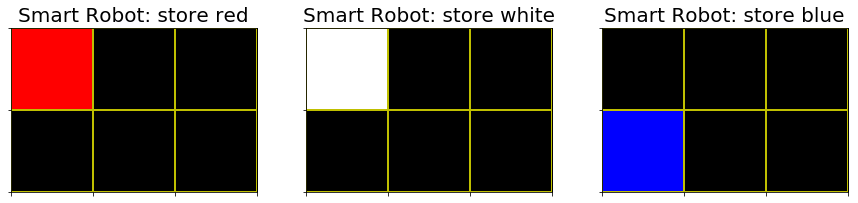

In [0]:
plt.figure(figsize=(15,15))

smart_robot = Smart(6, value_policy, states)
smart_robot.next_action('store', 'red')
plt.subplot(131)
smart_robot.show(smart_robot.reward)

smart_robot = Smart(6, value_policy, states)
smart_robot.next_action('store', 'white')
plt.subplot(132)
smart_robot.show(smart_robot.reward)

smart_robot = Smart(6, value_policy, states)
smart_robot.next_action('store', 'blue')
plt.subplot(133)
smart_robot.show(smart_robot.reward)

# Storing two Products of the same Color

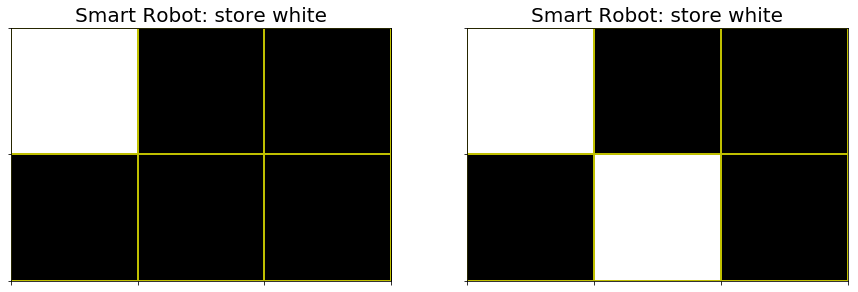

In [0]:
plt.figure(figsize=(15,15))

smart_robot = Smart(6, value_policy, states)
smart_robot.next_action('store', 'white')
plt.subplot(121)
smart_robot.show(smart_robot.reward)

smart_robot.next_action('store', 'white')
plt.subplot(122)
smart_robot.show(smart_robot.reward)


# Check Policy for Refusal of Storing

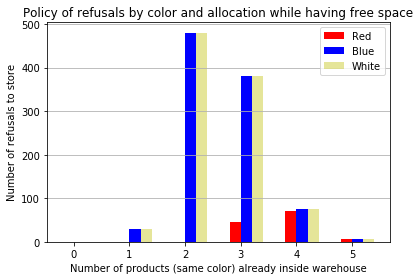

In [6]:
def policy_check_refuse(states, policy, plot=False):
    action = {'sr': 'store red',
             'sb': 'store blue',
             'sw': 'store white',
             'rr': 'restore red',
             'rb': 'restore blue',
             'rw': 'restore white'}
    refuse_red = [0, 0, 0, 0, 0, 0]
    refuse_blue = [0, 0, 0, 0, 0, 0]
    refuse_white = [0, 0, 0, 0, 0, 0]
    col = ['red', 'blue', 'white']

    for st, pol in zip(states, policy):
        if st[-1][0] == 's':
            if st[pol] != '0':
                if st.count('0') != 0:
                    #print('State: {}, refused to {}, Policy {}'.format(st, action[st[-1]], pol))
                    pass
                if st[-1][1] == 'r':
                    if st.count('0') != 0:
                        refuse_red[st.count('r')] += 1
                if st[-1][1] == 'b':
                    if st.count('0') != 0:
                        refuse_blue[st.count('b')] += 1
                if st[-1][1] == 'w':
                    if st.count('0') != 0: 
                        refuse_white[st.count('w')] += 1
    for idx_col, ref in enumerate([refuse_red, refuse_blue, refuse_white]):
        for idx_num, j in enumerate(ref):
            print('Refused {} {} times if {} {} already inside warehouse and there was free space.'.format(col[idx_col], j, idx_num, col[idx_col]))
            pass
    if plot:
        n_groups = len(refuse_red)

        fig, ax = plt.subplots()

        index = np.arange(n_groups)
        bar_width = 0.2

        opacity = 0.4
        error_config = {'ecolor': '0.3'}

        rects1 = plt.bar(index, refuse_red, bar_width,                        
                         color='r',
                         error_kw=error_config,
                         label='Red')

        rects2 = plt.bar(index + bar_width, refuse_blue, bar_width,           
                         color='b',                         
                         error_kw=error_config,
                         label='Blue')
        
        rects3 = plt.bar(index + 2*bar_width, refuse_white, bar_width,
                         alpha=opacity,
                         color='y',                       
                         error_kw=error_config,
                         label='White')

        plt.xlabel('Number of products (same color) already inside warehouse')
        plt.ylabel('Number of refusals to store')
        plt.title('Policy of refusals by color and allocation while having free space')
        plt.xticks(index + bar_width / 2, ('0', '1', '2', '3', '4', '5'))
        plt.legend()

        plt.tight_layout()
        plt.grid(axis='y')
        plt.show()
    
policy_check_refuse(states, value_policy, plot=True)

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code